# HamletMTA Progress Report 2

- [David Hadaller](#David-Hadaller)
- [Angelika Shastapalava](#Angelika-Shastapalava)
- [Sam Mundle](#Sam-Mundle)
- [Excel Espina](#Excel-Espina)

## Project Aims

We will use MTA bus data, Monte Carlo passenger simulation and weather data to create a model that will determine how long a passenger should wait for the next bus, before giving up and chosing an alternative mode of transportation. Our focus thus far has been on one particular bus stop (the southbound M100 on 135th street) in August of 2017. However, this model could be iterated system-wide for every bus stop location. 

The diagram below serves as a reference for our analysis and is explained in more detail in the passages that follow.

![diagram](analysis_diagram.png)

### Monte Carlo Simulation

In our Monte Carlo simulation, we will first assume that there is a uniform probability that a passenger will approach a stop at any given time of day. The reason for this choice is for it's realism (it is a common assumtion among staff analysts at the MTA's operations and planning department) and for it's ease of computation. Later on, we can experiment different ridership behaviors such as a bimodal probability distribution (peak in the early morning and evening for commuters). 

#### Passenger Wait Times ([Sam](#Sam-Mundle))

We view each day's bus arrivals, at a given bus stop, as points on a timeline. Similarly, each  passenger arival at the bus stop falls also on the day's timeline. Calculating wait times then amounts to finding the difference between the passenger's arrival and the arrival of the very next bus along this timeline. Our goal here is to create a dataset with the time (as in time of day) of a passenger's approach to the bus station as the independent variable and the wait time as the dependent variable. This data will serve as the validation set for our model.

#### Bus Time Deltas/headways ([David](#David-Hadaller))

For the simulated passengers, each approaching the bus stop at some random time, we would like to find how crowded the bus they board will be. To find this, we will simulate many passengers "boarding" busses by assigning a population of $n$ daily passengers a uniform random timestamp between the last and first busses of the day. Buses which feature an abnormally long timedelta (long time interval between current and last bus arrival) will generally be more crowded, since more passengers accumulate at the bus stop as time goes on. Again, the time of day is our independent variable and the number of people on the bus (crowding) is the dependent variable.  This data will serve as the validation set for our model.

### Weather Data ([Angelika](#Angelika-Shastapalava))

Weather data will include columns for precipitation, wind speed, and visibility for the month of August 2017 in NYC. These will serve as our features for predicting crowding and wait time.


### Machine Learning Model ([Excel](#Excel-Espina))

The feature variables will be include weather data columns and time of day, while the target variables will be the crowding and wait times as experienced by the passengers (to predict what we simulated in the Monte Carlo method step.) Our goal is to produce a general weather-conscious model that predicts passenger experience (wait time and crowdedness)

Considerations for this step include, but are not limited to:

- model evaluation (accuracrecall,prediction, lift and all that)
- model type (linear, non linear/ regression/decision tree)


## Data Sources

[MTA Schedules](http://web.mta.info/nyct/service/bus/bklnsch.htm#top) (need to figure out best way to scrape or source better structured data)

[MTA Bus Statistics](https://www.kaggle.com/stoney71/new-york-city-transport-statistics)

[Weather.Gov](https://www.weather.gov/okx/CentralParkHistorical) Data from a weather monitor in central park; Each day, a 1:30 am report holds 24 hours of weather data starting at 12:00 am EST the previous day and the reports look like [this](https://forecast.weather.gov/product.php?site=NWS&issuedby=NYC&product=CLI&format=CI&version=1&glossary=1&highlight=off).

# David Hadaller

In [1]:
import pandas as pd
import matplotlib.dates
import matplotlib.pyplot as plt
import numpy as np
import datetime, math

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
M100_NICK = pd.read_csv('M100_month_W125_st.csv')
M100_NICK.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime', 'time_delta', 'time_delta_mins', 'time_diff',
       'time_diff_mins'],
      dtype='object')

Before we begin the simulation, we need to establish what will become the arguments to `numpy.random.uniform(low=0.0, high=1.0, size=None)`. Below, we find the `low` and `high` parameters. That is, we find the first and last bus arrival times for each day.

In [3]:
DailyBusMinMax= M100_NICK.loc[:,['RecordedAtTime']]
splitCol = DailyBusMinMax['RecordedAtTime'].str.split(' ', 1, expand=True).rename(columns={0:'Date', 1:'Time'}) 
DailyBusMinMax['Date']= splitCol['Date'] 

DailyBusMinMax = DailyBusMinMax.drop_duplicates()

DailyBusMax = DailyBusMinMax.groupby('Date').max()
DailyBusMin = DailyBusMinMax.groupby('Date').min()

DailyBusMinMax = pd.merge(left=DailyBusMin, right=DailyBusMax, how='inner',on='Date', suffixes=('Min', 'Max'))
DailyBusMinMax = DailyBusMinMax.rename(columns={'RecordedAtTimeMin':'EarliestBusArrival', 'RecordedAtTimeMax':'LatestBusArrival'})

DailyBusMinMax.reset_index(level=0, inplace=True)
DailyBusMinMax['Date'] = pd.to_datetime(DailyBusMinMax['Date'],format='%Y-%m-%d')
DailyBusMinMax['EarliestBusArrival'] = pd.to_datetime(DailyBusMinMax['EarliestBusArrival'], format='%Y-%m-%d %H:%M:%S')
DailyBusMinMax['LatestBusArrival'] = pd.to_datetime(DailyBusMinMax['LatestBusArrival'], format='%Y-%m-%d %H:%M:%S')

DailyBusMinMax.head()

,Date,EarliestBusArrival,LatestBusArrival
0,2017-08-01,2017-08-01 07:51:49,2017-08-01 18:42:04
1,2017-08-02,2017-08-02 15:54:31,2017-08-02 19:14:42
2,2017-08-03,2017-08-03 13:06:46,2017-08-03 18:17:14
3,2017-08-04,2017-08-04 11:28:26,2017-08-04 21:48:55
4,2017-08-05,2017-08-05 15:10:31,2017-08-05 21:40:50


In the cell below, we take the bus arrival times (when the bus pulls into the stop), the dates associated with each bus arrival time (to help with subsequent merges) and the timedeltas (which we may plot later on) from the original `M100_NICK` data

In [4]:
BusArrivals = M100_NICK.loc[:,['RecordedAtTime','time_delta_mins']]
dates = M100_NICK['RecordedAtTime'].str.split(' ', 1, expand=True).rename(columns={0:'Date'})
BusArrivals.insert(loc=0, column='Date', value=dates['Date'])

BusArrivals = BusArrivals.rename(columns={'RecordedAtTime':'BusArrivalTime'})

# Change Column DataTypes from String (object) to DateTime
BusArrivals['BusArrivalTime'] = pd.to_datetime(BusArrivals['BusArrivalTime'], format='%Y-%m-%d %H:%M:%S')
BusArrivals['Date'] = pd.to_datetime(BusArrivals['Date'], format='%Y-%m-%d %H:%M:%S')
BusArrivals = BusArrivals.drop_duplicates()

BusArrivals.head()

,Date,BusArrivalTime,time_delta_mins
0,2017-08-01,2017-08-01 07:51:49,0
3,2017-08-01,2017-08-01 11:02:25,191
4,2017-08-01,2017-08-01 13:42:23,161
5,2017-08-01,2017-08-01 13:52:39,10
6,2017-08-01,2017-08-01 15:53:02,121


Next, we define a simulation function which gets the `low` and `high` bounds of the uniform distribution from the DailyBusMinMax dataframe and then takes `NumPassengers` for population size of passengers to simulate. 

This simulation function creates a "pivot table" with the Date as pseudo-index and an artificial passengerId for column headers. For each date, the table contains each passenger in NumPassengers simulated bus arrival time (the time at which each passenger approaches the bus stop with the hopes of boarding a bus.)

Of course, the table that results isn't a true pivot table, because the Date column is just another column, rather than a pandas index. Keeping the Date as a column allows us to reference it as a column later on, which will come in handy when we need to return a series of dates.

In [5]:
def passengerSim(DailyBusMinMax, NumPassengers):
    
    #time between the first and last bus arrivals
    dailyDelta = DailyBusMinMax['LatestBusArrival'] - DailyBusMinMax['EarliestBusArrival']
    
    # the first bus arrival
    dailyMin = DailyBusMinMax['EarliestBusArrival']
    
    #number of dates to simulate for
    NumDates = len(DailyBusMinMax.Date)
    
    #this vectorized calculation follows the formula dailyDelta * randomVar + firstBusArrival to choose a random time
        # between the EarliestBusArrival and the LatestBusArrival.
        # this is done for every date and for each passenger in NumPassengers
    pSim = pd.DataFrame(np.random.uniform(0,1,(NumDates,NumPassengers)))
    pSim = pSim.mul(dailyDelta,axis=0)
    pSim = pSim.add(dailyMin,axis=0)
    
    # add a dates column to front of dataframe  
    pSim.insert(loc=0, column='Date', value=DailyBusMinMax['Date'])
    
    return pSim

In [6]:
sim = passengerSim(DailyBusMinMax,500)
sim.head()

,Date,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,2017-08-01,2017-08-01 13:45:12.269147378,2017-08-01 11:45:31.893612739,2017-08-01 08:21:34.411089854,2017-08-01 14:19:24.043797514,2017-08-01 16:06:09.413214793,2017-08-01 08:30:15.495755921,2017-08-01 14:26:47.239664946,2017-08-01 09:58:41.433239831,2017-08-01 14:49:22.894365230,...,2017-08-01 15:34:13.575746396,2017-08-01 10:37:26.798065088,2017-08-01 15:20:34.922167679,2017-08-01 08:55:13.952167801,2017-08-01 17:32:18.779927537,2017-08-01 09:55:23.174272681,2017-08-01 09:47:31.461002255,2017-08-01 12:05:45.005324368,2017-08-01 10:27:19.576252309,2017-08-01 11:04:36.509814573
1,2017-08-02,2017-08-02 16:42:23.852259675,2017-08-02 16:40:56.387861565,2017-08-02 17:23:24.072515200,2017-08-02 19:11:00.226819523,2017-08-02 15:56:17.974613714,2017-08-02 18:29:25.847315710,2017-08-02 18:00:16.432930346,2017-08-02 17:13:14.152546895,2017-08-02 16:17:53.103887602,...,2017-08-02 16:57:15.700395617,2017-08-02 16:53:32.896603478,2017-08-02 16:42:20.481865858,2017-08-02 17:03:58.846346133,2017-08-02 16:06:53.918871476,2017-08-02 18:19:37.164779423,2017-08-02 17:04:37.164196740,2017-08-02 17:33:45.350972773,2017-08-02 15:58:18.648603854,2017-08-02 16:42:46.838675293
2,2017-08-03,2017-08-03 15:59:12.836314833,2017-08-03 15:31:49.622680345,2017-08-03 13:59:30.322672014,2017-08-03 14:05:05.665025816,2017-08-03 14:45:49.560153948,2017-08-03 17:13:31.967004427,2017-08-03 14:11:34.099797041,2017-08-03 16:16:45.265377921,2017-08-03 18:03:32.776740776,...,2017-08-03 17:11:15.393304026,2017-08-03 18:00:51.096829243,2017-08-03 13:23:31.665785252,2017-08-03 17:05:17.422774375,2017-08-03 16:01:20.910654805,2017-08-03 16:26:04.127618270,2017-08-03 15:12:10.515363654,2017-08-03 17:27:35.011899698,2017-08-03 17:13:49.198627559,2017-08-03 14:35:24.629232537
3,2017-08-04,2017-08-04 13:40:43.638779401,2017-08-04 14:40:08.348130975,2017-08-04 21:11:34.115687474,2017-08-04 18:04:07.796635932,2017-08-04 19:43:14.793372878,2017-08-04 13:21:20.702448540,2017-08-04 21:10:31.966920445,2017-08-04 19:19:58.006629146,2017-08-04 15:04:06.950751800,...,2017-08-04 16:11:22.759461262,2017-08-04 21:34:11.308534038,2017-08-04 18:02:46.388227967,2017-08-04 20:26:51.404124037,2017-08-04 13:09:33.949341499,2017-08-04 17:19:25.112770660,2017-08-04 12:14:46.464385900,2017-08-04 17:50:07.068274564,2017-08-04 12:39:22.151995440,2017-08-04 15:24:11.613654398
4,2017-08-05,2017-08-05 18:15:02.624841740,2017-08-05 18:22:24.656395192,2017-08-05 21:21:38.366058076,2017-08-05 18:12:30.072616295,2017-08-05 15:31:21.087866266,2017-08-05 21:23:02.734027948,2017-08-05 20:41:08.942913345,2017-08-05 19:34:10.087901291,2017-08-05 21:36:55.919771266,...,2017-08-05 17:11:06.896626328,2017-08-05 17:12:30.679786864,2017-08-05 15:15:08.640431424,2017-08-05 16:33:29.396665513,2017-08-05 16:10:15.980302212,2017-08-05 15:27:31.650071358,2017-08-05 15:28:21.364562527,2017-08-05 15:24:46.995302720,2017-08-05 20:24:13.030096515,2017-08-05 15:24:32.819685090


Here, we reorganize the results of the passenger simulation to get a table that has one single `passengerId` column, instead of one column for each passenger. This is will allow us to perform a merge in the following step.

In [7]:
sim = sim.melt(id_vars='Date')
sim = sim.rename(columns={'variable':'passengerId','value':'passengerArrivalTime'})
sim.head()

,Date,passengerId,passengerArrivalTime
0,2017-08-01,0,2017-08-01 13:45:12.269147378
1,2017-08-02,0,2017-08-02 16:42:23.852259675
2,2017-08-03,0,2017-08-03 15:59:12.836314833
3,2017-08-04,0,2017-08-04 13:40:43.638779401
4,2017-08-05,0,2017-08-05 18:15:02.624841740


As promised, we now merge the passenger simulation,`sim` with the bus arrival times, `BusArrivals`. The result of the code below is a lookup table where each passenger arrival time is associated with one bus arrival time; that is to say, the passengers are associated with the bus they board (which will always be the next bus that approaches the stop after they arrive.)

In [8]:
# The powerset of all passenger-bus combinations
busBoarding = pd.merge(right=sim, left=BusArrivals, on='Date', how='inner')

# whittle down previous dataframe to those where passengers board busses that arrive at stop after they do
    # (no going back in time)
busBoarding = busBoarding.loc[busBoarding['BusArrivalTime']>=busBoarding['passengerArrivalTime']]

# the passenger is reasonable and will board the first bus that approaches the stop
busBoarding = busBoarding.groupby(['Date','passengerId','passengerArrivalTime']).first()

# we reset the index to group by a different column in the next step
busBoarding = busBoarding.reset_index().sort_values(['Date','BusArrivalTime','passengerId'])
busBoarding.head()

,Date,passengerId,passengerArrivalTime,BusArrivalTime,time_delta_mins
2,2017-08-01,2,2017-08-01 08:21:34.411089854,2017-08-01 11:02:25,191
5,2017-08-01,5,2017-08-01 08:30:15.495755921,2017-08-01 11:02:25,191
7,2017-08-01,7,2017-08-01 09:58:41.433239831,2017-08-01 11:02:25,191
9,2017-08-01,9,2017-08-01 09:44:50.120861893,2017-08-01 11:02:25,191
10,2017-08-01,10,2017-08-01 10:07:38.099348065,2017-08-01 11:02:25,191


Now, we calcuate the number of people per bus by grouping by `BusArrivalTime` and then counting the number of entries in each group. We then merge this `busCrowding` DataFrame back into our `busBoarding` DataFrame from the previous step to give us a `numPassengersPerBus` column, which tells us exactly how many of our simulated passengers boarded each bus.

In [16]:
busCrowding = busBoarding.groupby(['BusArrivalTime']).count()
busCrowding = pd.DataFrame(busCrowding['passengerId']).rename(columns={'passengerId':'numPassengersPerBus'})
busCrowding.reset_index()

busBoarding = pd.merge(left=busBoarding, right=busCrowding, on='BusArrivalTime', how='inner')
busBoarding.head()
busBoarding.shape

(14000, 7)

We now take a few columns of the `busBoarding`data that to plot the relationship between `passengerArrivalTime` and `numPassengersPerBus`.

In [15]:
plotData = busBoarding.loc[:,['passengerArrivalTime','numPassengersPerBus']]
plotData['passengerArrivalTime'] = plotData.passengerArrivalTime.dt.time
plotData.head()
plotData.shape

(14000, 2)

Finally, we have our plot.

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.,  80000.,  90000.]),
 <a list of 11 Text xticklabel objects>)

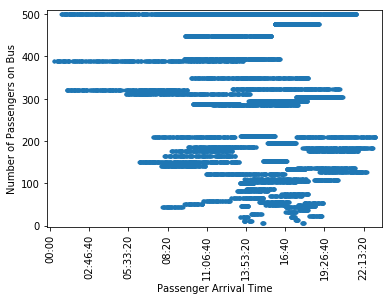

In [11]:
plotData = plotData.sort_values('passengerArrivalTime', ascending=True)
_= plt.plot(plotData['passengerArrivalTime'], plotData['numPassengersPerBus'],'.',linestyle='none')
_ = plt.xlabel('Passenger Arrival Time')
_ = plt.ylabel('Number of Passengers on Bus')
_ = plt.margins(0.02) # Keeps data off plot edges
plt.xticks(rotation='vertical')

Notice that the above plot features a series of points a the 1000 people mark. This signifies that there are busses so crowded that they fit 1000 passengers inside. Clearly there is an innacuracy in the data. The source of the problem is that there is only one bus per day on some days, but the daily population of passengers remains 1000 every day. So far as we can see, there can be two causes for this error: 

1. Some of the bus arrival data has been unnecessarily deleted or is missing; there are no "one-bus-only" days at this stop.
2. The number of passengers should be adapted to the number of busses for each transit day. This would mean the error was setting the daily ridership at a constant of `numPassengers=1000`.

However, once find the source of this error, we will have our "base truth" to help train our models on in the next phase of our project. 

# Sam Mundle

In [12]:
# Find the elapsed time between passenger arrival and bus arrival (Wait time)
busBoarding['WaitTime'] = busBoarding['BusArrivalTime'] - busBoarding['passengerArrivalTime']
busBoarding.shape

(14000, 6)

In [26]:
waitPlotData = busBoarding[['passengerArrivalTime', 'WaitTime']].copy()
waitPlotData['passengerArrivalTime'] = waitPlotData.passengerArrivalTime.dt.time
waitPlotData.dtypes

passengerArrivalTime             object
WaitTime                timedelta64[ns]
dtype: object

(array([    0.,  5000., 10000., 15000., 20000., 25000.]),
 <a list of 6 Text xticklabel objects>)

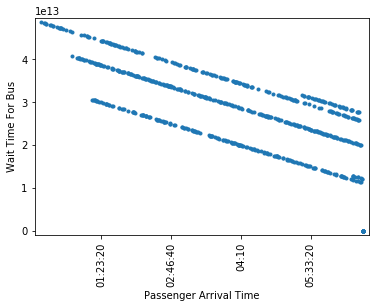

In [29]:
waitPlotData = waitPlotData.sort_values('passengerArrivalTime', ascending=True)[0:500]
_= plt.plot(waitPlotData['passengerArrivalTime'], waitPlotData['WaitTime'],'.',linestyle='none')
_ = plt.xlabel('Passenger Arrival Time')
_ = plt.ylabel('Wait Time For Bus')
_ = plt.margins(0.02) # Keeps data off plot edges
plt.xticks(rotation='vertical')



First we import relevant libraries and generate a dataframe representing all of the arrivals at a single stop in a single month traveling in one of two directions on the M100 bus route. 

It should be noted that there are relatively few entries for the month (107) due to data loss earlier in the cleaning process. Further work on cleaning is necessary

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

mta_df = pd.read_csv('M100_month_W125_st.csv', error_bad_lines=False)
mta_df.shape

(107, 21)

Then the dataframe is sorted based on 'RecordedAtTime' which, since all entries are while the bus has reached the stop, represent the actual arrival times. 

In [3]:
mta_df['RecordedAtTime'] = pd.to_datetime(mta_df['RecordedAtTime'])
mta_df.sort_values("RecordedAtTime", inplace=True)
mta_df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,time_delta,time_delta_mins,time_diff,time_diff_mins
0,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,...,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:49:06,NaN,0,NaN,0
1,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,...,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:50:48,0 days 00:00:00.000000000,0,0 days 00:00:00.000000000,0
2,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,...,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:51:39,0 days 00:00:00.000000000,0,0 days 00:00:00.000000000,0
3,2017-08-01 11:02:25,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8384,...,-73.952928,W 125 ST/ST NICHOLAS AV,at stop,11.0,2017-08-01 11:02:42,11:04:39,0 days 03:10:39.000000000,191,0 days 03:10:39.000000000,191
4,2017-08-01 13:42:23,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8391,...,-73.952865,W 125 ST/ST NICHOLAS AV,at stop,17.0,2017-08-01 13:43:07,13:35:20,0 days 02:40:25.000000000,161,0 days 02:40:25.000000000,161


The arrivals dataframe is initialized with a controlled number of passenger arrival time entries and can have the frequency of random times changed in its definition statement

In [5]:
def select_random_dates(frequency, NumDataPoints):
    date_range = pd.date_range(start='2017-08-01', end='2017-08-30', freq=frequency)
    random_dates = pd.to_datetime(
        np.concatenate([
                np.random.choice(date_range[1:-1], size=NumDataPoints, replace=False)
            ])
        )
    return random_dates

arrivals_df = pd.DataFrame()
arrivals_df['PassengerTime'] = select_random_dates('1min', 600)
arrivals_df.head(10)

,PassengerTime
590,2017-08-06 22:58:00
591,2017-08-04 09:46:00
592,2017-08-15 08:14:00
593,2017-08-06 04:08:00
594,2017-08-19 14:26:00
595,2017-08-02 01:34:00
596,2017-08-28 13:16:00
597,2017-08-24 06:35:00
598,2017-08-28 09:44:00
599,2017-08-15 04:29:00


The next arriving bus is found for each of the random passenger arrival times defined above as well as the time delta between the two, representing wait time.

In [6]:
def findNextBus(arrivals_df, mta_df):
    for arrivalIndex, arrivalRow in arrivals_df.iterrows():
        for mtaIndex, mtaRow in mta_df.iterrows():
            if (mtaRow['RecordedAtTime'] > arrivalRow[0]):
                arrivals_df.loc[arrivalIndex,'NextBus'] = mtaRow['RecordedAtTime']
                break

findNextBus(arrivals_df, mta_df)
arrivals_df['WaitTime'] = arrivals_df['NextBus'] - arrivals_df['PassengerTime']
arrivals_df.head(10)

,PassengerTime,NextBus,WaitTime
0,2017-08-08 03:18:00,2017-08-08 09:45:00,06:27:00
1,2017-08-11 15:10:00,2017-08-11 15:30:37,00:20:37
2,2017-08-06 12:57:00,2017-08-06 13:42:10,00:45:10
3,2017-08-01 13:28:00,2017-08-01 13:42:23,00:14:23
4,2017-08-28 22:31:00,2017-08-29 09:32:09,11:01:09
5,2017-08-05 22:48:00,2017-08-06 00:10:28,01:22:28
6,2017-08-20 05:26:00,2017-08-20 06:35:28,01:09:28
7,2017-08-10 13:36:00,2017-08-10 18:19:26,04:43:26
8,2017-08-18 07:01:00,2017-08-18 08:32:51,01:31:51
9,2017-08-03 09:26:00,2017-08-03 13:06:46,03:40:46


# Angelika Shastapalava

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import numpy as np


reading the file

In [2]:
df = pd.read_csv("/Users/angelika/Desktop/cs59970/1401011.csv", delimiter = ',', usecols = (5,24), index_col='DATE')

In [3]:
df.head()

,HOURLYPrecip
DATE,
2008-01-01 00:51,0.00
2008-01-01 01:51,0.00
2008-01-01 02:51,0.00
2008-01-01 03:51,0.00
2008-01-01 04:51,0.00


In [4]:
df.dtypes


HOURLYPrecip    object
dtype: object

selecting time period of aug 2017

In [5]:
weather = df.loc['2017-08-01' : '2017-09-01']

In [6]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1006 entries, 2017-08-01 00:51 to 2017-08-31 23:59
Data columns (total 1 columns):
HOURLYPrecip    823 non-null object
dtypes: object(1)
memory usage: 15.7+ KB


our data contains some na values. in addition some precip values contain 
letter 'T' or 's'.
droping na and precip values that contain T or s letter in them

In [7]:
weather = weather.dropna()
weather = weather[~weather.HOURLYPrecip.str.contains("T")]
weather = weather[~weather.HOURLYPrecip.str.contains("s")]

In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 798 entries, 2017-08-01 00:51 to 2017-08-31 23:51
Data columns (total 1 columns):
HOURLYPrecip    798 non-null object
dtypes: object(1)
memory usage: 12.5+ KB


In [9]:
weather.HOURLYPrecip=pd.to_numeric(weather.HOURLYPrecip)
weather.reset_index()

,DATE,HOURLYPrecip
0,2017-08-01 00:51,0.0
1,2017-08-01 01:51,0.0
2,2017-08-01 02:51,0.0
3,2017-08-01 03:51,0.0
4,2017-08-01 04:51,0.0
5,2017-08-01 05:51,0.0
6,2017-08-01 06:51,0.0
7,2017-08-01 07:51,0.0
8,2017-08-01 08:51,0.0
9,2017-08-01 09:51,0.0


Text(0,0.5,'Hourly Precipitation in Inches')

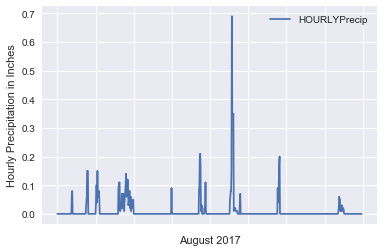

In [10]:
%matplotlib inline
import seaborn; seaborn.set()
weather.plot(y='HOURLYPrecip', use_index=True)
plt.xlabel('August 2017')
plt.ylabel('Hourly Precipitation in Inches')

creating another df for visibility

In [11]:
vis = pd.read_csv("/Users/angelika/Desktop/cs59970/1401011.csv", delimiter = ',', usecols = (5,8),index_col='DATE')

In [12]:
vis.head()

,HOURLYVISIBILITY
DATE,
2008-01-01 00:51,10.00
2008-01-01 01:51,9.00
2008-01-01 02:51,10.00
2008-01-01 03:51,10.00
2008-01-01 04:51,9.00


In [13]:
vis.dtypes

HOURLYVISIBILITY    object
dtype: object

selecting time period of aug 2017

In [14]:
visib = vis.loc['2017-08-01' : '2017-09-01']

In [15]:
visib.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1006 entries, 2017-08-01 00:51 to 2017-08-31 23:59
Data columns (total 1 columns):
HOURLYVISIBILITY    975 non-null object
dtypes: object(1)
memory usage: 15.7+ KB


droping na values and data that contain string 'V' in it

In [16]:
visib = visib.dropna()
visib = visib[~visib.HOURLYVISIBILITY.str.contains("V")]

In [17]:
visib.info()

<class 'pandas.core.frame.DataFrame'>
Index: 967 entries, 2017-08-01 00:51 to 2017-08-31 23:51
Data columns (total 1 columns):
HOURLYVISIBILITY    967 non-null object
dtypes: object(1)
memory usage: 15.1+ KB


converting visibility column to numeric in order to create a plot

In [18]:
visib.HOURLYVISIBILITY=pd.to_numeric(visib.HOURLYVISIBILITY)

Text(0,0.5,'Hourly Visibility in miles')

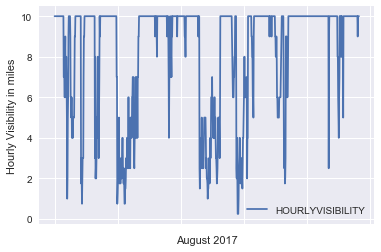

In [19]:
visib.plot(y='HOURLYVISIBILITY', use_index=True)
plt.xlabel('August 2017')
plt.ylabel('Hourly Visibility in miles')

Let's see what dates hourly visibility was below 1 mile

In [20]:
visib.loc[visib.HOURLYVISIBILITY < 1]

,HOURLYVISIBILITY
DATE,
2017-08-04 06:40,0.75
2017-08-07 08:11,0.75
2017-08-07 13:47,0.75
2017-08-07 13:51,0.75
2017-08-18 07:40,0.25
2017-08-18 07:49,0.25
2017-08-18 07:51,0.25


Let's see what dates horly precipitation was above 0.5 inches

In [21]:
weather.loc[weather.HOURLYPrecip >= 0.5]

,HOURLYPrecip
DATE,
2017-08-18 07:51,0.69


It seems like on august 18th precipitation was relatively high and visibility was low
This is important because it can influence waiting time and crowdiness in busses.
For better understanding lets visualize it with seaborn plots

Text(0,0.5,'Hourly Visibility in miles')

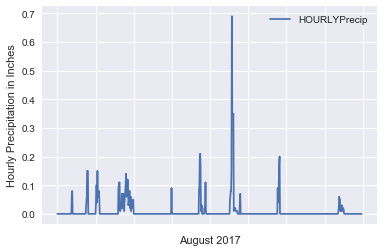

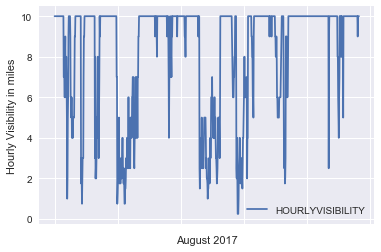

In [22]:
weather.plot(y='HOURLYPrecip', use_index=True)
plt.xlabel('August 2017')
plt.ylabel('Hourly Precipitation in Inches')

visib.plot(y='HOURLYVISIBILITY', use_index=True)
plt.xlabel('August 2017')
plt.ylabel('Hourly Visibility in miles')

Indeed, we have low hourly visibility and high precipitation 
around the same time (aug 18th).
We can expect this date to have longer waiting time and 
higher crowdiness in busses in our future model

Let's see if there any other dates that can influence our 
dependable variables

In [23]:
print(visib.loc[visib.HOURLYVISIBILITY < 2])
print(weather.loc[weather.HOURLYPrecip >= 0.2])

                  HOURLYVISIBILITY
DATE                              
2017-08-02 16:46              1.00
2017-08-04 06:07              1.75
2017-08-04 06:30              1.75
2017-08-04 06:40              0.75
2017-08-07 08:11              0.75
2017-08-07 08:26              1.25
2017-08-07 09:59              1.75
2017-08-07 10:51              1.75
2017-08-07 12:53              1.75
2017-08-07 13:38              1.75
2017-08-07 13:47              0.75
2017-08-07 13:51              0.75
2017-08-07 14:14              1.50
2017-08-07 14:19              1.50
2017-08-15 02:08              1.50
2017-08-15 13:00              1.75
2017-08-15 13:21              1.00
2017-08-15 13:51              1.50
2017-08-15 14:15              1.50
2017-08-15 15:10              1.75
2017-08-16 02:18              1.75
2017-08-18 07:23              1.75
2017-08-18 07:40              0.25
2017-08-18 07:49              0.25
2017-08-18 07:51              0.25
2017-08-18 08:05              1.00
2017-08-18 09:19    

It seems like on aug 15th and 22nd there is 
a hight chance of finding disruption of bus services as well

Now, let's find out if there were any dates with hight wind speed

In [24]:
w = pd.read_csv("/Users/angelika/Desktop/cs59970/1401011.csv", delimiter = ',', usecols = (5,17), index_col='DATE')

In [25]:
w.head()

,HOURLYWindSpeed
DATE,
2008-01-01 00:51,0.0
2008-01-01 01:51,6.0
2008-01-01 02:51,6.0
2008-01-01 03:51,5.0
2008-01-01 04:51,5.0


In [26]:
w.dtypes

HOURLYWindSpeed    float64
dtype: object

In [27]:
print(w.shape)
print(len(w))

(119500, 1)
119500


Selecting time period of aug 2017

In [28]:
wind = w.loc['2017-08-01' : '2017-09-01']

In [29]:
wind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1006 entries, 2017-08-01 00:51 to 2017-08-31 23:59
Data columns (total 1 columns):
HOURLYWindSpeed    926 non-null float64
dtypes: float64(1)
memory usage: 15.7+ KB


In [30]:
wind = wind.dropna()

In [31]:
wind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 926 entries, 2017-08-01 00:51 to 2017-08-31 23:51
Data columns (total 1 columns):
HOURLYWindSpeed    926 non-null float64
dtypes: float64(1)
memory usage: 14.5+ KB


In [32]:
wind.HOURLYWindSpeed.describe().astype(int)

count    926
mean       3
std        2
min        0
25%        0
50%        3
75%        6
max       15
Name: HOURLYWindSpeed, dtype: int64

Text(0,0.5,'Hourly wind speed in miles')

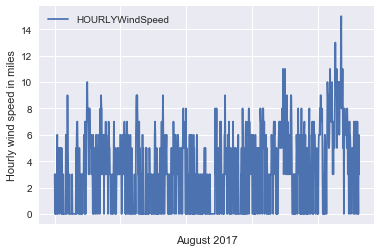

In [33]:
wind.plot(y='HOURLYWindSpeed', use_index=True)
plt.xlabel('August 2017')
plt.ylabel('Hourly wind speed in miles')

From the plot it looks like highest wind speed occured
towards the end of the month

In [34]:
wind.loc[wind.HOURLYWindSpeed > 8]

,HOURLYWindSpeed
DATE,
2017-08-02 15:51,9.0
2017-08-04 13:51,9.0
2017-08-04 14:51,10.0
2017-08-05 15:51,9.0
2017-08-08 08:51,9.0
2017-08-08 09:51,9.0
2017-08-11 16:51,9.0
2017-08-17 02:51,9.0
2017-08-22 16:51,11.0


Indeed our observation was correct.
However, we know that on aug 15th, 18th and 22nd 
our other 2 independant variables were relatively high/low.
Higher than usual wind speed during those days would 
probably influence our dependent varibles even more.
Let's see what wind speed we had on aug 15th, 18th and 22nd 
but before that let's convert index to datetime so we can use it later for 
creating our model

In [35]:
wind = wind.reset_index()

In [36]:
wind.head()

,DATE,HOURLYWindSpeed
0,2017-08-01 00:51,3.0
1,2017-08-01 01:51,0.0
2,2017-08-01 02:51,0.0
3,2017-08-01 03:51,3.0
4,2017-08-01 04:51,0.0


In [37]:
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 926 entries, 0 to 925
Data columns (total 2 columns):
DATE               926 non-null object
HOURLYWindSpeed    926 non-null float64
dtypes: float64(1), object(1)
memory usage: 14.5+ KB


In [38]:
wind.DATE = pd.to_datetime(wind.DATE)

In [39]:
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 926 entries, 0 to 925
Data columns (total 2 columns):
DATE               926 non-null datetime64[ns]
HOURLYWindSpeed    926 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.5 KB


In [40]:
print(wind.loc[(wind.DATE >= '2017-08-15') & (wind.DATE <= '2017-08-16') ].max())
print(wind.loc[(wind.DATE >= '2017-08-18') & (wind.DATE <= '2017-08-19') ].max())
print(wind.loc[(wind.DATE >= '2017-08-22') & (wind.DATE <= '2017-08-23') ].max())

DATE               2017-08-15 23:51:00
HOURLYWindSpeed                      6
dtype: object
DATE               2017-08-18 23:51:00
HOURLYWindSpeed                      8
dtype: object
DATE               2017-08-22 23:51:00
HOURLYWindSpeed                     11
dtype: object


As we can see max wind speed on aug 18th and 22ns was 
8 and 11 mph respectively
this also can influence out predictors.
We need to convert DATE to datetime for precipitation and visibility as well

In [41]:
weather = weather.reset_index()

In [42]:
weather.DATE = pd.to_datetime(weather.DATE)

In [43]:
visib = visib.reset_index()
visib.DATE = pd.to_datetime(visib.DATE)

In [44]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 2 columns):
DATE            798 non-null datetime64[ns]
HOURLYPrecip    798 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.5 KB


In [45]:
visib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 2 columns):
DATE                967 non-null datetime64[ns]
HOURLYVISIBILITY    967 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.2 KB


We are finished with cleaning and analyzing weather data.
Our observations show that there are certain days when we can expect higher crowdiness 
and longer wait time for the busses. 

Now we ready to integrate the data to our model as independant variables and see
if our predictions were correct. 

# Excel Espina

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, train_test_split

warnings.filterwarnings("ignore")
random_state = 20181112
import datetime, math, glob

Adding data from the M100 csv file.

In [2]:
%%capture
df = pd.read_csv('M100_Aug_W125_st.csv', error_bad_lines=False)

# Choosing the Best Classifier

We want (a) regressor(s) that can predict the **wait time** and **crowding** of a bus at a specific stop with the inputs **hourly weather** and **time of day**. We would most likely have two models that predict each **wait time** and **crowding**.

Here are our top picks for regressors:

1. Gradient Boosting Machines ***(top pick)***:
    - Why: GBMs are typically a composite model that combines the efforts of multiple weak models to create a strong model, and each additional weak model reduces the mean squared error (MSE) of the overall model. Our goal would be to minimize MSE to increase the accuracy of our predictions.

1. Random Forest:
    - Why: does not suffer from the overfitting like with Decision Trees. Instead of randomly choosing to split from just **hourly weather** and **time of day**, we can have two trees that randomly split from each and find the best model. 

1. Decision Trees:  
    - Reduction in Standard Deviation (metric): This is a regression metric that measures how much we’ve reduced our uncertainty by picking a split point. By picking the best split each time the greedy decision tree training algorithm tries to form decisions with as few splits as possible.  
    - Hyperparameters:   
        * Max depth: Limit our tree to a `n` depth to prevent overfitting.
        

Evaluating our model:

Since we're creating regression models, we are interested in the ***mean squared error*** and ***R Squared***. The lower our ***R Squared*** the more accurate our model. We intend to use **K-fold cross validation** as well as a **holdout set** as we improve our model through hyperparameter tuning. 

    * Preventing 

# Data Cleaning

What we need to do:  

1. Clean and break up the time components (Hour, Mins, Secs) of the following:
    * `RecordedAtTime`
    * `ExpectedArrivalTime`
    * `ScheduledArrivalTime`
    
2. Store features of interest:
    * `RecordedAtTime`
    * `VehicleLocation.Longitude`
    * `VehicleLocation.Latitude`
    * `DistanceFromStop`
    * `ExpectedArrivalTime`
   

In [3]:
df['ScheduledArrivalTime'] = pd.to_datetime(df.ScheduledArrivalTime, errors='coerce')
df.dropna()
df['Scheduled_Hour'] = df['ScheduledArrivalTime'].dt.hour
df['Scheduled_Minute'] = df['ScheduledArrivalTime'].dt.minute
df['Scheduled_Seconds'] = df['ScheduledArrivalTime'].dt.second

df['RecordedAtTime'] = pd.to_datetime(df.RecordedAtTime)
df['Recorded_Hour'] = pd.to_datetime(df.RecordedAtTime).dt.hour
df['Recorded_Minute'] = pd.to_datetime(df.RecordedAtTime).dt.minute
df['Recorded_Seconds'] = pd.to_datetime(df.RecordedAtTime).dt.second

df['ExpectedArrivalTime'] = pd.to_datetime(df.ExpectedArrivalTime)
df['Expected_Hour'] = pd.to_datetime(df.ExpectedArrivalTime).dt.hour
df['Expected_Minute'] = pd.to_datetime(df.ExpectedArrivalTime).dt.minute
df['Expected_Seconds'] = pd.to_datetime(df.ExpectedArrivalTime).dt.second

In [4]:
df.dtypes

RecordedAtTime               datetime64[ns]
DirectionRef                          int64
PublishedLineName                    object
OriginName                           object
OriginLat                           float64
OriginLong                          float64
DestinationName                      object
DestinationLat                      float64
DestinationLong                     float64
VehicleRef                           object
VehicleLocation.Latitude            float64
VehicleLocation.Longitude           float64
NextStopPointName                    object
ArrivalProximityText                 object
DistanceFromStop                    float64
ExpectedArrivalTime          datetime64[ns]
ScheduledArrivalTime         datetime64[ns]
time_diff_bus                        object
time_diff_bus_mins                    int64
Scheduled_Hour                      float64
Scheduled_Minute                    float64
Scheduled_Seconds                   float64
Recorded_Hour                   

In [5]:
df.count()

RecordedAtTime               89
DirectionRef                 89
PublishedLineName            89
OriginName                   89
OriginLat                    89
OriginLong                   89
DestinationName              89
DestinationLat               89
DestinationLong              89
VehicleRef                   89
VehicleLocation.Latitude     89
VehicleLocation.Longitude    89
NextStopPointName            89
ArrivalProximityText         89
DistanceFromStop             89
ExpectedArrivalTime          89
ScheduledArrivalTime         86
time_diff_bus                88
time_diff_bus_mins           89
Scheduled_Hour               86
Scheduled_Minute             86
Scheduled_Seconds            86
Recorded_Hour                89
Recorded_Minute              89
Recorded_Seconds             89
Expected_Hour                89
Expected_Minute              89
Expected_Seconds             89
dtype: int64

In [20]:
features = (['VehicleLocation.Longitude', 
             'VehicleLocation.Latitude', 
             'OriginLong',
             'OriginLat',
             'DistanceFromStop',
             'Recorded_Hour',
             'Scheduled_Hour',
             'Scheduled_Minute',
             'Scheduled_Seconds',
             'Recorded_Minute',
             'Recorded_Seconds',
             'time_diff_bus_mins'
            ])

model_df = df[(features)].dropna().reset_index()

model_df.count()

index                        86
VehicleLocation.Longitude    86
VehicleLocation.Latitude     86
OriginLong                   86
OriginLat                    86
DistanceFromStop             86
Recorded_Hour                86
Scheduled_Hour               86
Scheduled_Minute             86
Scheduled_Seconds            86
Recorded_Minute              86
Recorded_Seconds             86
time_diff_bus_mins           86
dtype: int64

# Plotting a Chart for Sanity

We want to have a frequency/histogram for each hour of the day and for each minute of the hour.

Credit: David

In [7]:
def ecdf(inputSeries, label):
    try:
        x = np.sort(inputSeries)
    except:
        print("Warning: Series Unsorted")
        x = inputSeries
    y = np.arange(1, len(x)+1) / len(x)
    _ = plt.plot(x, y, marker='.', linestyle='none')
    _ = plt.xlabel('Time Delta ({})'.format(label))
    _ = plt.ylabel('ECDF')
    plt.margins(0.02) # Keeps data off plot edges
    plt.show()
    
def hist(inputSeries, label):
    plt.hist(inputSeries, bins=25, density=True)
    _ = plt.xlabel('Time Delta ({})'.format(label))
    _ = plt.ylabel('PDF')
    plt.show()

In [8]:
M100_NICK_Avg = df[['Recorded_Hour','time_diff_bus_mins', 'Recorded_Minute']]
M100_Hour = M100_NICK_Avg.groupby('Recorded_Hour').mean().dropna()
M100_Min = M100_NICK_Avg.groupby('Recorded_Minute').mean().dropna()
M100_NICK_Avg.head()

,Recorded_Hour,time_diff_bus_mins,Recorded_Minute
0,7,0,51
1,7,0,51
2,7,0,51
3,11,191,2
4,13,161,42


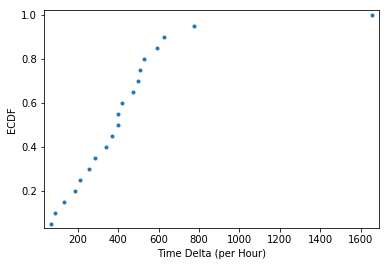

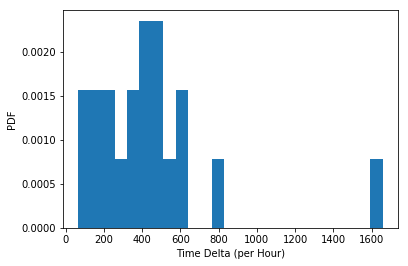

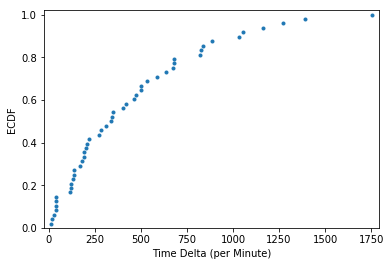

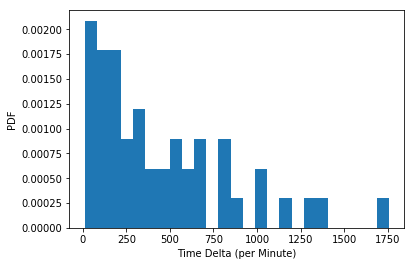

In [9]:
ecdf(M100_Hour['time_diff_bus_mins'], "per Hour")
hist(M100_Hour['time_diff_bus_mins'], "per Hour")

ecdf(M100_Min['time_diff_bus_mins'], "per Minute")
hist(M100_Min['time_diff_bus_mins'], "per Minute")

# Saving our Progress

In [10]:
model_df.to_csv('M100_4_month_W125_st_timesplit.csv', encoding='utf-8', index=False)

Splitting training and testing datasets

In [23]:
train_df, holdout_df, y_train, y_holdout = train_test_split(model_df[features],
                                                    model_df['time_diff_bus_mins'],
                                                    test_size=0.3,
                                                    random_state=42)

train_df['time_diff_bus_mins'] = y_train
holdout_df['time_diff_bus_mins'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

print(train_df.shape[0], train_df.time_diff_bus_mins.mean())
print(holdout_df.shape[0], holdout_df.time_diff_bus_mins.mean())

60 399.6666666666667
26 586.4615384615385


# Model Training

Let's take a quick look at all of our classification model options using cross validation. For the tree based models, we'll use the hyperparameter `max_depth=6` as a naive attempt at voiding overfitting before we dig deeper.

Let's fit and score the model, this time using cross validation:

In [12]:
k_fold = KFold(n_splits=5, random_state=random_state)

In [13]:
def get_cv_results(classifier):
    
    results = []
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, 'time_diff_bus_mins'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = accuracy_score(train_df.loc[test, 'time_diff_bus_mins'], y_predicted)
        results.append(accuracy)
    
    return np.mean(results), np.std(results)


Logistic Regression

In [14]:
logreg = LogisticRegression(
    random_state=random_state, 
    solver='lbfgs'
)

get_cv_results(logreg)

(0.048717948717948711, 0.039846846840820647)

Decision Tree

In [15]:
dtree = DecisionTreeClassifier(
    random_state=random_state, 
    max_depth=6
)

get_cv_results(dtree)

(0.17948717948717946, 0.099058686010676203)

Random Forest

In [16]:
rforest = RandomForestClassifier(
    random_state=random_state, 
    max_depth=6,
    n_estimators=100
)

get_cv_results(rforest)

(0.066666666666666666, 0.081649658092772595)

Gradient Boosting Machines

In [17]:
gbm = GradientBoostingClassifier(
    random_state=random_state, 
    max_depth=6,
    n_estimators=100
)

get_cv_results(gbm)

(0.13205128205128203, 0.11363343490338634)

# Evaluating Model Performance

We're using ROC curves to visually see which model performs the best.

In [21]:
def plot_roc(classifier, label, color):

    classifier.fit(train_df[features], train_df['time_diff_bus_mins'])
    y_prob = classifier.predict_proba(holdout_df[features])
    
    fpr, tpr, thresh = roc_curve(holdout_df['time_diff_bus_mins'], y_prob[:,1])
    plt.plot(fpr, tpr,
             label=label,
             color=color, linewidth=3)

    auc = roc_auc_score(holdout_df['time_diff_bus_mins'], y_prob[:,1])
    
    print('AUC: %0.3f (%s)' % (auc, label))

In [24]:
f1 = plt.figure(figsize=(14,6))

logreg = LogisticRegression(
    random_state=random_state, 
    solver='lbfgs'
)
plot_roc(logreg, 'Logistic Regression', 'green')

dtree = DecisionTreeClassifier(
    random_state=random_state, 
    max_depth=3
)
plot_roc(dtree, 'Decision Tree', 'red')

rforest = RandomForestClassifier(
    random_state=random_state, 
    max_depth=6,
    n_estimators=100
)
plot_roc(rforest, 'Random Forest', 'blue')

gbm = GradientBoostingClassifier(
    random_state=random_state, 
    max_depth=6,
    n_estimators=100
)
plot_roc(gbm, 'GBM', 'lightblue')

plt.legend(loc='lower right')

ValueError: multiclass format is not supported